### Start

In [1]:
def encode(df):
    le = preprocessing.LabelEncoder()
    le.fit(df)
    return(le.transform(df))

def normalize(df):
    return pd.Series(df).str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ','_').str.lower().str.strip().tolist()    

In [2]:
def clean(df, ano):
    df = df.drop(columns=['Unnamed: 16'])
    df.columns = normalize(df.columns)
    mask = df['orgao'].notnull()
    df = df[mask]
    
    for col in df.columns[-6:]:
        df[col] = df[col].str.replace('.','').str.replace(',','.')
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    categoria = {
        '3' :  'DESPESAS CORRENTES',
        '4' :  'DESPESAS DE CAPITAL',
        '9' :  'RESERVA DE CONTINGENCIA',
    }
    
    df['categoria'] = df['elemento'].apply(lambda x: x[:1]).replace(categoria)

    
    grupo = {
        '31' : 'PESSOAL E ENCARGOS SOCIAIS',
        '32' : 'JUROS E ENCARGOS DA DIVIDA',
        '33' : 'OUTRAS DESPESAS CORRENTES',
        '44' : 'INVESTIMENTOS',
        '45' : 'INVERSOES FINANCEIRAS',
        '46' : 'AMORTIZACAO DE DIVIDA',
        '99' : 'RESERVA DE CONTINGENCIA'
    }
    
    df['grupo'] = df['elemento'].apply(lambda x: x[:2]).replace(grupo)
    
    modalidade = {
        '3120' :  'TRANSFERENCIAS A UNIAO',
        '3190' :  'APLICACOES DIRETAS',
        '3191' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIA',
        '3290' :  'APLICACOES DIRETAS',
        '3291' :  'APLICACOES DIRETAS INTRA-ORCAMENTARIAS',
        '3320' :  'TRANSFERENCIAS A UNIAO',
        '3340' :  'TRANSFERENCIAS A MUNICIPIOS',
        '3341' :  'TRANSFERENCIAS A MUNICIPIOS - FUNDO A FUNDO',
        '3350' :  'TRANSF.A INST.PRIVADAS SEM FINS LUCRATIVOS',
        '3360' :  'TRANSF.A INST.PRIVADAS COM FINS LUCRATIVOS',
        '3367' :  'EXECUCAO DE CONTRATO DE PPP',
        '3370' :  'TRANSF.A INSTIT.MULTIGOVERN.NACIONAIS',
        '3380' :  'TRANSFERENCIAS AO EXTERIOR',
        '3390' :  'APLICACOES DIRETAS',
        '3391' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIAS',
        '4420' :  'TRANSFERENCIAS A UNIAO',
        '4440' :  'TRANSFERENCIAS A MUNICIPIOS',
        '4450' :  'TRANSF.A INSTIT.PRIVADAS SEM FINS LUCRATIVOS',
        '4490' :  'APLICACOES DIRETAS',
        '4491' :  'APLICACOES DIRETAS-INTRA ORCAMENTARIAS',
        '4567' :  'EXECUCAO DE CONTRATO DE PPP',
        '4590' :  'APLICACOES DIRETAS',
        '4591' :  'APLIC.DIRETAS-OP.ENTRE ENTID.INTEGR.ORCAMENT',
        '4690' :  'APLICACOES DIRETAS',
        '4691' :  'APLICACOES DIRETAS INTRA-ORCAMENTARIAS',
        '9999' :  'RESERVA DE CONTINGENCIA',

    }
    
    df['modalidade'] = df['elemento'].apply(lambda x: x[:4]).replace(modalidade)

    
    
    return(df)

### PIE Plot

### Sankey Plot

In [3]:
def sankey_plot(df_18,source,target,valor):
    cols = source + target
    cols = list(set(cols))

    df_sankey = df_18.groupby(by = cols, as_index=False, sort=False).sum()[cols + [valor]]
    color = '#300101'

    df_sankey = df_sankey.sort_values(by=cols)
    
    
    df_final = pd.DataFrame()

    for i in range(len(source)):
        df_aux = pd.DataFrame()

        print(source[i], target[i])


        df_aux['source'] = df_sankey[source[i]]
        df_aux['target'] = df_sankey[target[i]]
        df_aux['value']  = df_sankey[valor]
        df_final = pd.concat([df_final,df_aux], axis=0)
        
    label = df_final['source'].tolist() + df_final['target'].tolist()
    # value = df_sankey['orgaos_count'].tolist() + df_sankey['grupo_count'].tolist()
    df = pd.DataFrame(label,columns = ['label'])
    # df['number'] = value
    df = df.drop_duplicates(subset='label', keep='first')
    df['number'] = [i for i in range(len(df))]
    
    df_final = pd.merge(df_final,df, left_on = ['source'], right_on=['label'], how = 'left', suffixes=('_orgao','_bla') ).rename(columns = {'number':'source_num'})
    df_final = pd.merge(df_final,df, left_on = ['target'], right_on=['label'], how = 'left', suffixes=('_orgao','_bla') ).rename(columns = {'number':'target_num'})
    
    ####plot####
    
    
    
    trace1 = go.Sankey(
        orientation='h',
        arrangement = "snap",
        
        domain={
            'x':[0,1],
            'y':[0,1],
        },
        
        node = {
            "label"     : df['label'],
            'pad'       : 10,
            'thickness' : 50,
            'line' : {
                'width' : 2,
            },
            'hoverinfo' : "all"
            
        },  # 10 Pixels 

        link = {
            'source' : df_final['source_num'],
            'target' : df_final['target_num'],
            'value' : df_final['value']
        }
    )
    
    layout =  dict(
        height = 1100,
    #         width = 1200,
        font = dict(
          size = 10
        ),    
    )
    
    fig = go.Figure(data = trace1, layout=layout)
    
    iplot(fig) 
#     return(df_final,df)



In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns

### Perfil Historico

In [5]:
# mater df
df_final = pd.DataFrame()

##################################################### 2010-2019 #####################################################

#years to get
anos = [str(i) for i in range(2010,2020)]

for ano in anos:
    #read year by year
    df = pd.read_csv('../data/orcamento/orcamento_{}.csv'.format(ano), encoding="ISO-8859-9")
    df_18 = clean(df,ano)

    #padronizer
    df_18['elemento'] = df_18['elemento'].str.split('-').apply(lambda x: x[1]).str.strip()
    df_18['orgao'] = df_18['orgao'].str.split('-').apply(lambda x: x[1]).str.strip()
    df_18['ano']=ano
    
    #append to final df
    df_final = pd.concat([df_final,df_18], axis=0)

#just fell cols
cols = ['ano','orgao','unidade_gestora','fonte_de_recursos','programa','acao','grupo','dotacao_inicial']
df_total = df_final[cols]

##################################################### 2020 #####################################################

#get LOA FROM 2020 
ano = '2020'
#read file
df = pd.read_excel('../data/orcamento/orcamento_{}.xlsx'.format(ano), encoding="utf-8")
#normalize columns
df.columns = normalize(df.columns)
df_20 = df.copy()
#normalize orgaos
df_20['orgao'] = df_20['orgao'].str.split('-').apply(lambda x: x[1]).str.strip()
df_20['orgao'] = normalize(df_20['orgao'])
df_20['orgao'] = df_20['orgao'].str.replace('_',' ').str.upper()
#normalize grupos
df_20['grupo'] = df_20['grupo'].str.replace('INVESTIMENTOS','INVESTIMENTO').str.replace('INVESTIMENTO','INVESTIMENTOS').str.upper().str.strip()
df_20['grupo'] = normalize(df_20['grupo'])
df_20['grupo'] = df_20['grupo'].str.replace('_',' ').str.upper()
#create some columns
df_20['total'] = 'TOTAL'
df_20['programa']=df_20['programa'].apply(lambda x: x[18:]).str.strip()
df_20['ano'] = '2020'
#filter just some columns
cols = ['ano','orgao','unidade_gestora','fonte_de_recursos','programa','acao','grupo','dotacao_inicial']
df_20_f = df_20[cols]

##################################################### ALL YEARS #####################################################

#create a df with all years
df_total = pd.concat([df_total,df_20_f], axis=0)

#normalize grupo and remove anomalys
df_total['grupo'] = df_total['grupo'].str.replace('AMORTIZACAO DE DIVIDA','AMORTIZACAO DA DIVIDA')
mask = df_total['grupo']!='34'
df_total = df_total[mask]

##################################################### MAP ORGAOS #####################################################
#map the diferent orgaos
orgaos_match = pd.read_excel('../data/aux/orgaos_match.xlsx')
df = pd.merge(df_total,orgaos_match, left_on='orgao',right_on='old', how='left')

#grop aux cols
df['orgao'] = df['new']
df = df.drop(columns=['old','new'])
df = df.rename(columns={'dotacao_inicial':'valor'})

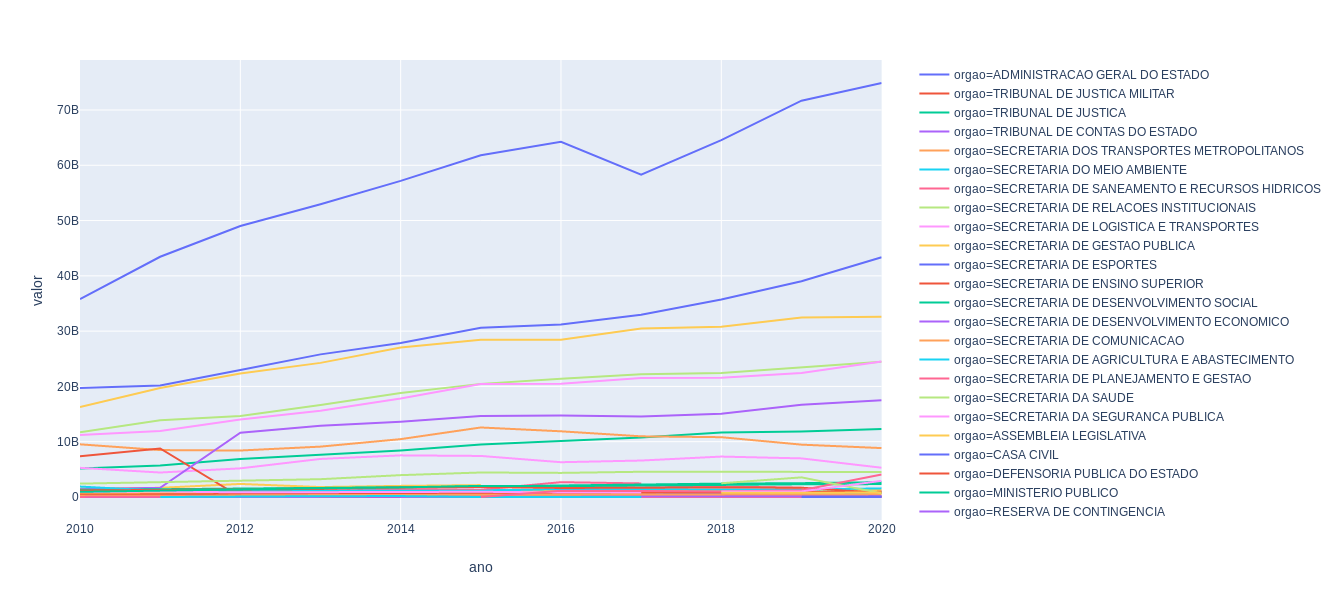

In [6]:
mask = df['grupo']=='PESSOAL E ENCARGOS SOCIAIS'

dd = df.groupby(by=['ano','orgao'], as_index=False).sum().sort_values(by='ano')
px.line(dd, x='ano', y='valor', color='orgao')

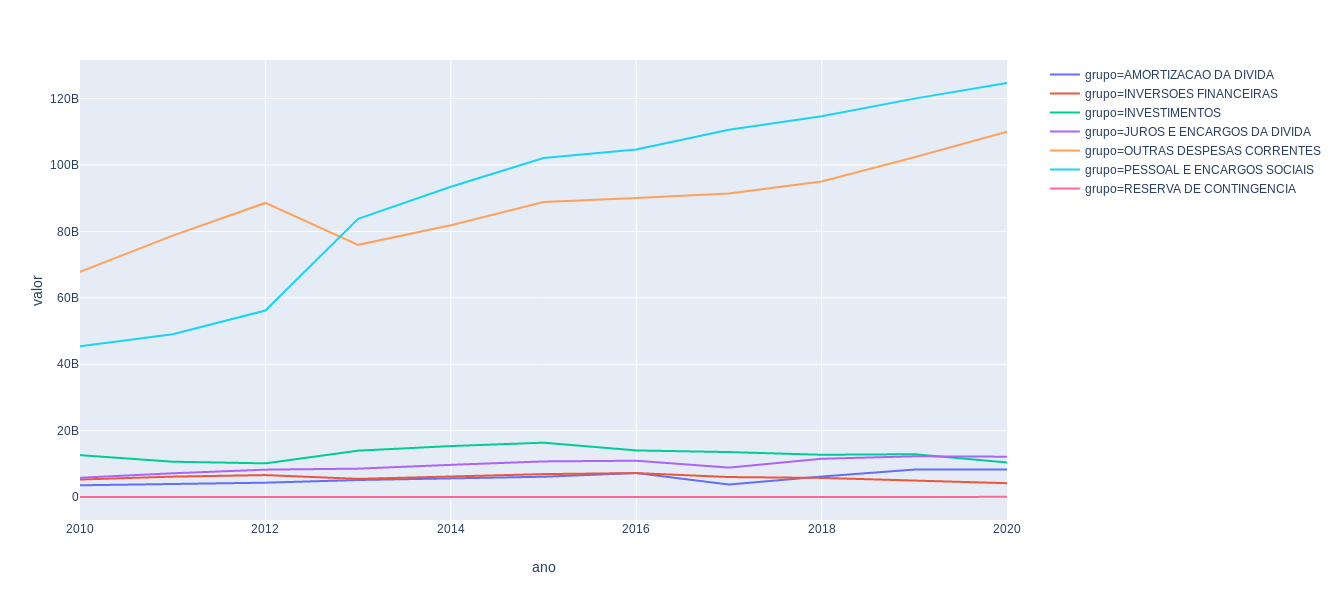

In [7]:
dd = df.groupby(by=['ano','grupo'], as_index=False).sum().sort_values(by='ano')
px.line(dd, x='ano', y='valor', color='grupo')

## Perfil Anual

In [36]:
mask = df['ano']=='2020'
df_ano          = df[mask]
df_ano['total'] = 'ORCAMENTO TOTAL'


mask = df['ano']=='2019'
df_19          = df[mask]
df_19['total'] = 'ORCAMENTO TOTAL'

### PIE

In [9]:
def pie_plot(dd,label='orgao',value='valor'):
    labels = dd[label]
    values = dd[value]
    trace = go.Pie(
        labels=labels,
        values=values,
        hoverinfo='label+percent+value',
        textinfo='percent',
        opacity = 0.90,
#         textposition='none',
        textposition='auto',

        marker=dict(
            line=dict(
                color='#000000',
                width=1)
        ),
    )

    layout =  dict(
        height = 600,
    #         width = 1200,
        font = dict(
          size = 10
        ),    
    )


    fig = go.Figure(data=[trace], layout=layout)
    fig.show()



### GERAL

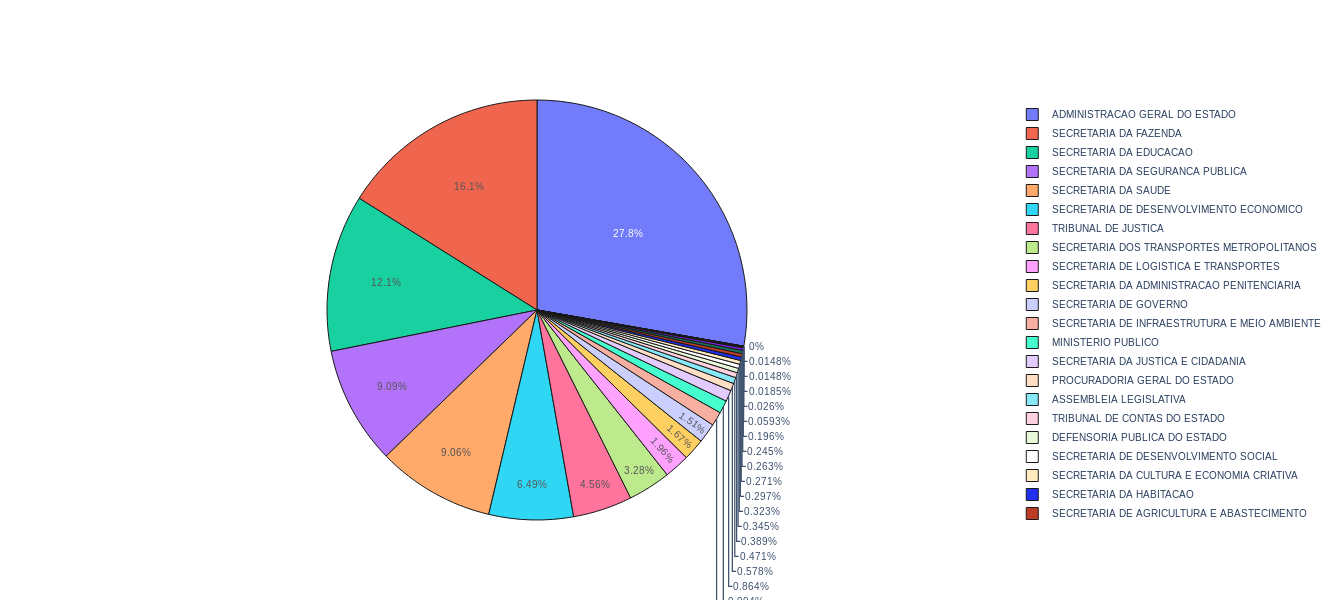

In [10]:
dd = df_ano.groupby(by='orgao', as_index=False).sum()
dd['valor'] = round(dd['valor']/10**9,2)
pie_plot(dd)

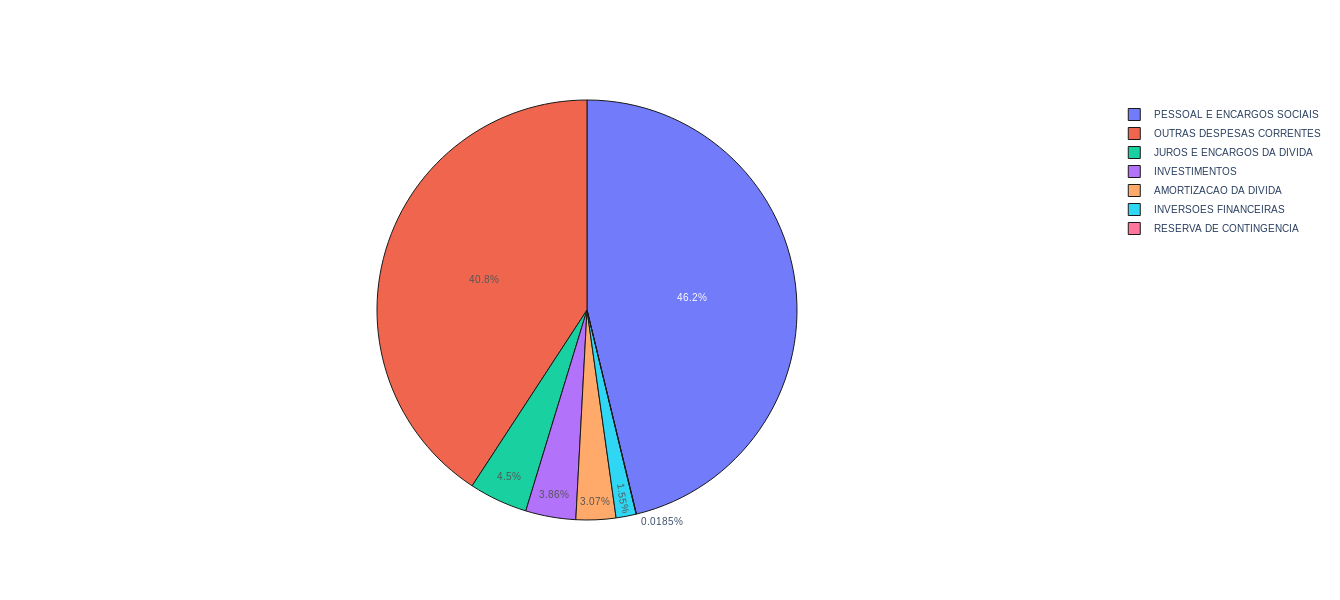

In [11]:
dd = df_ano.groupby(by='grupo', as_index=False).sum()
dd['valor'] = round(dd['valor']/10**9,2)
pie_plot(dd, label='grupo')

### Sankey

In [12]:
# cols = ['orgaos','unidade','programas','acao']
source = ['total']
target = ['orgao']
valor  = 'valor'

# sankey_plot(df_ano,source,target,valor)

In [13]:
mask = df_ano['orgao']=='SECRETARIA DA EDUCACAO'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'

# sankey_plot(educacao,source,target,valor)


In [14]:
mask = df_ano['orgao']=='SECRETARIA DA SAUDE'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'

# sankey_plot(educacao,source,target,valor)


In [15]:
mask = df_ano['orgao']=='SECRETARIA DA SEGURANCA PUBLICA'
educacao = df_ano[mask]

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'

# sankey_plot(educacao,source,target,valor)


In [49]:
mask = df_19['orgao'] == 'SECRETARIA DA FAZENDA'
df_19[mask]['programa'].unique()

array(['2000 - GESTAO FISCAL E TRIBUTARIA', '2826 - COMUNICACAO SOCIAL',
       '2005 - FOMENTO AO DESENVOLVIMENTO SOCIOECONOMICO',
       '0102 - OBRIGACOES PREVIDENCIARIAS EM COMPLEMENTACAO',
       '0001 - PARTICIPACAO SOCIETARIA', '0000 - ENCARGOS GERAIS',
       '2009 - ADMINISTRACAO GERAL DA SECRETARIA DA FAZENDA',
       '2900 - FORTALECIMENTO DO SISTEMA ESTADUAL DE PLANEJAMENTO E ORCAMENTO',
       '2921 - GESTAO DE PESSOAS',
       '2003 - GESTAO DAS CARTEIRAS AUTONOMAS DE PREVIDENCIA, DO IPESP E DE CONTRATOS DE SEGURO',
       '2021 - GESTAO DOS REGIMES PROPRIOS DE PREVIDENCIA ESTADUAL'],
      dtype=object)

array(['90010000 - CONTRIBUICAO PARA O REGIME PREVID.SERVIDORES',
       '57520000 - ADMINISTRACAO DA SAO PAULO PREVIDENCIA'], dtype=object)

orgao grupo
grupo acao


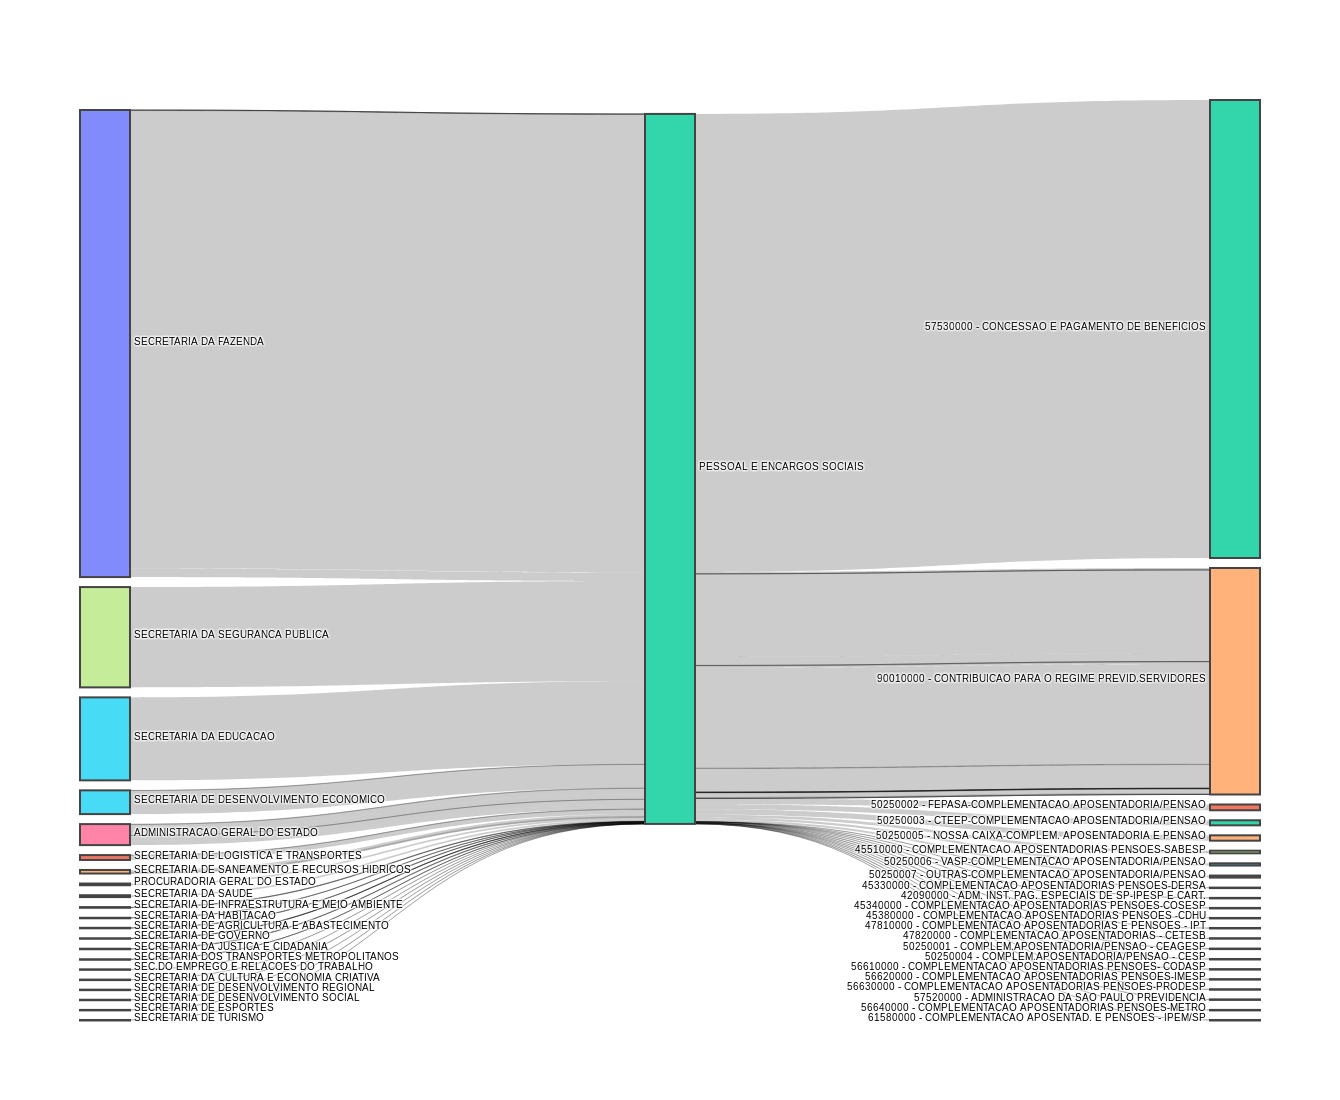

In [58]:
mask = df_19['grupo']=='PESSOAL E ENCARGOS SOCIAIS'
dd = df_19[mask]

mask =(dd['programa'].str.contains('PREVI')) | (dd['acao'].str.contains('PREVI'))

# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'

sankey_plot(dd[mask],source,target,valor)

orgao grupo
grupo acao


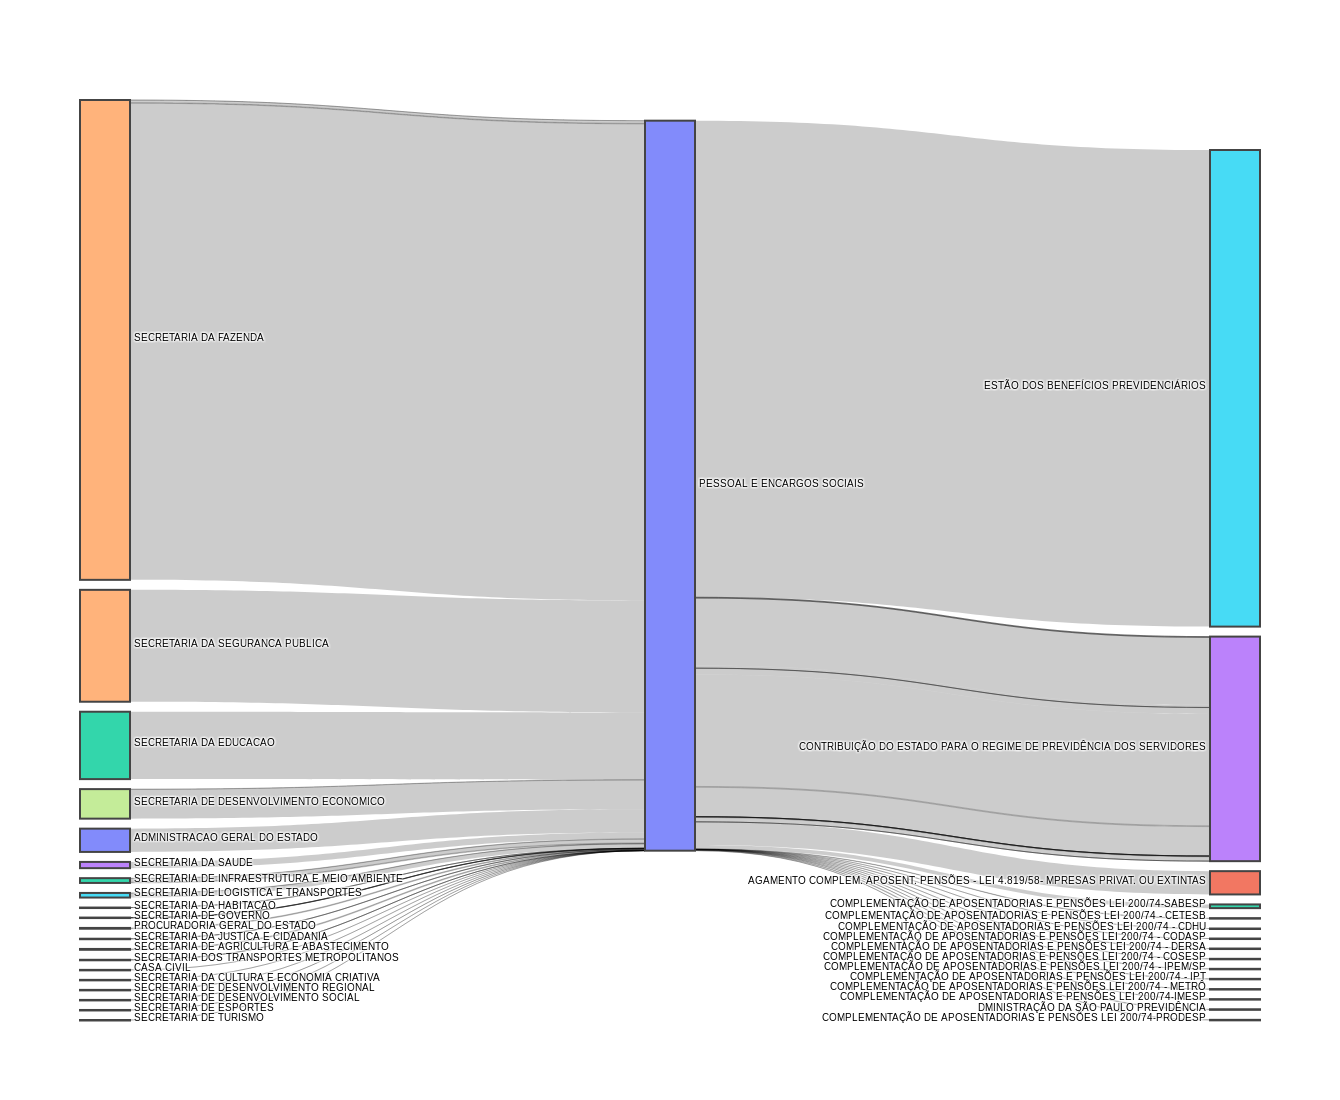

In [59]:
mask = df_ano['grupo']=='PESSOAL E ENCARGOS SOCIAIS'
dd = df_ano[mask]

mask = (dd['programa'].str.contains('PREVI')) | (dd['acao'].str.contains('PREVI'))
dd['tipo'] = np.where(mask,'INATIVO','ATIVO')


# cols = ['orgaos','unidade','programas','acao']
source = ['orgao','grupo']
target = ['grupo','acao']
valor  = 'valor'

sankey_plot(dd[mask],source,target,valor)


In [219]:
import json, urllib
# import chart_studio.plotly as py
import pandas as pd
import numpy as np

In [220]:
url = 'https://rawgit.com/monfera/plotly-webgl-parcoords/sankey-example-01/drones.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())

In [221]:
label = []
for x in data['data'][0]['nodes']:
    label.append(x['label'])
    
    
linkSource = []
linkValue = []    
linkTarget = []
linkLabel = []
for x in data['data'][0]['links']:
    linkLabel.append(x['label'])
    linkSource.append(x['source'])
    linkValue.append(x['value'])
    linkTarget.append(x['target'])

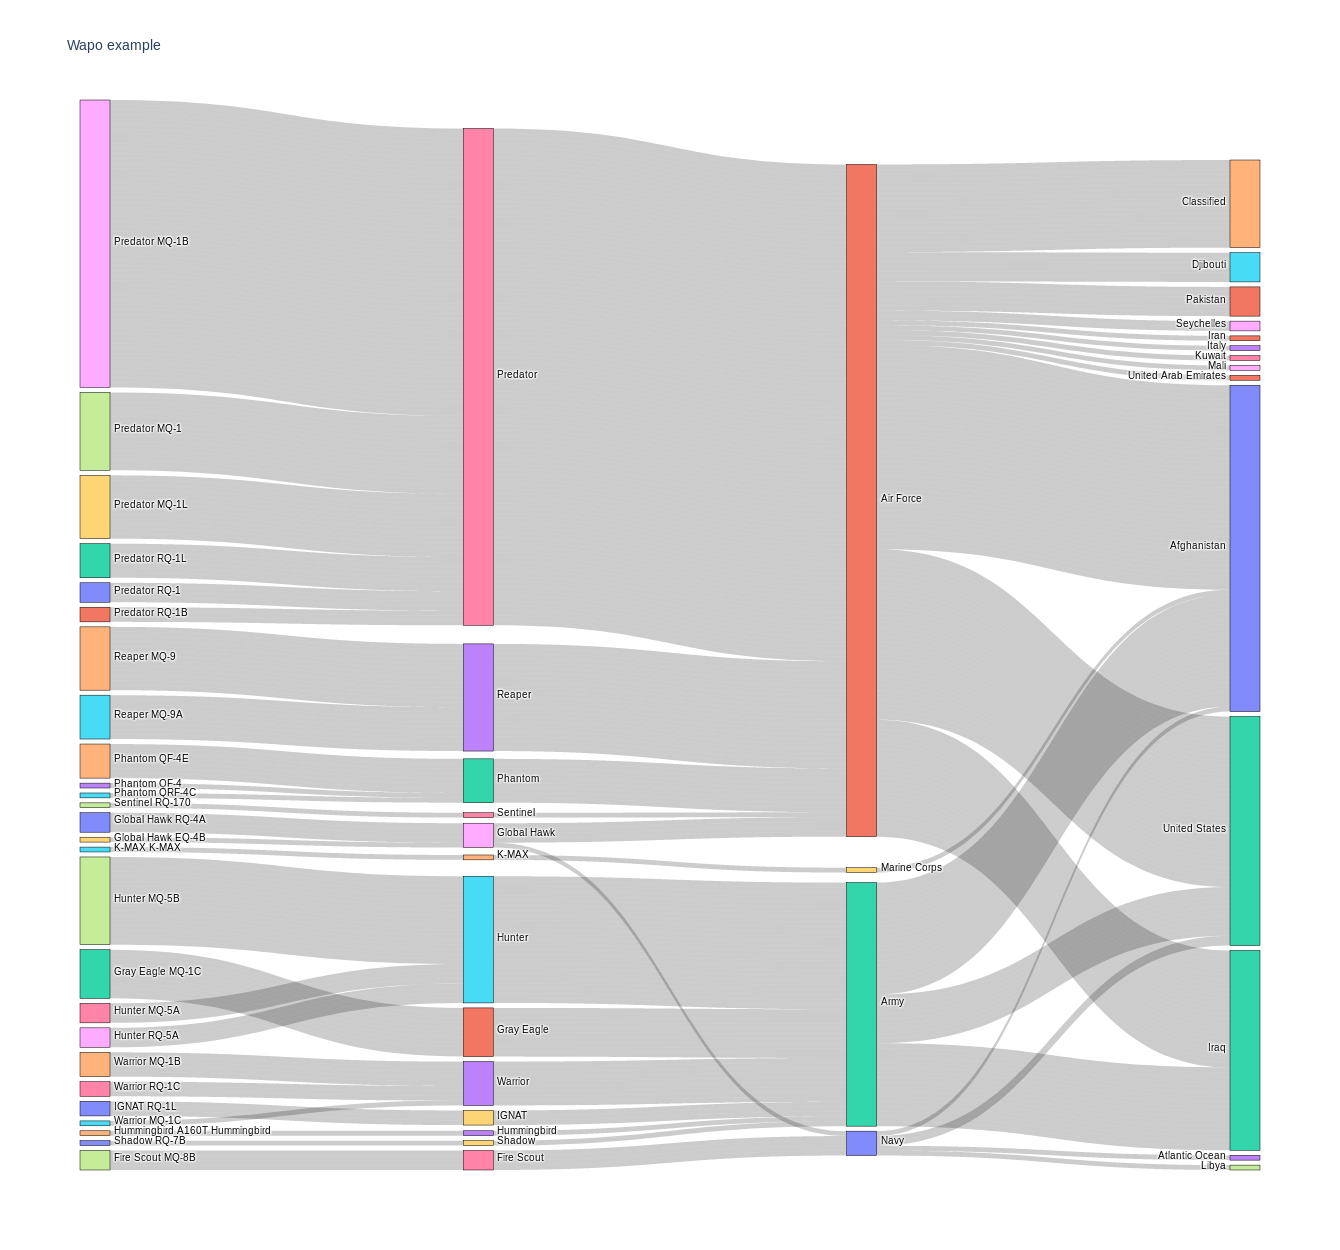

In [222]:
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  label
    ),
    link = dict(
      source = linkSource,
      target = linkTarget,
      value = linkValue,
      label =  linkLabel
  )
)

layout =  dict(
    title = "Wapo example",
    height = 1250,
    width = 1000,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
iplot(fig)

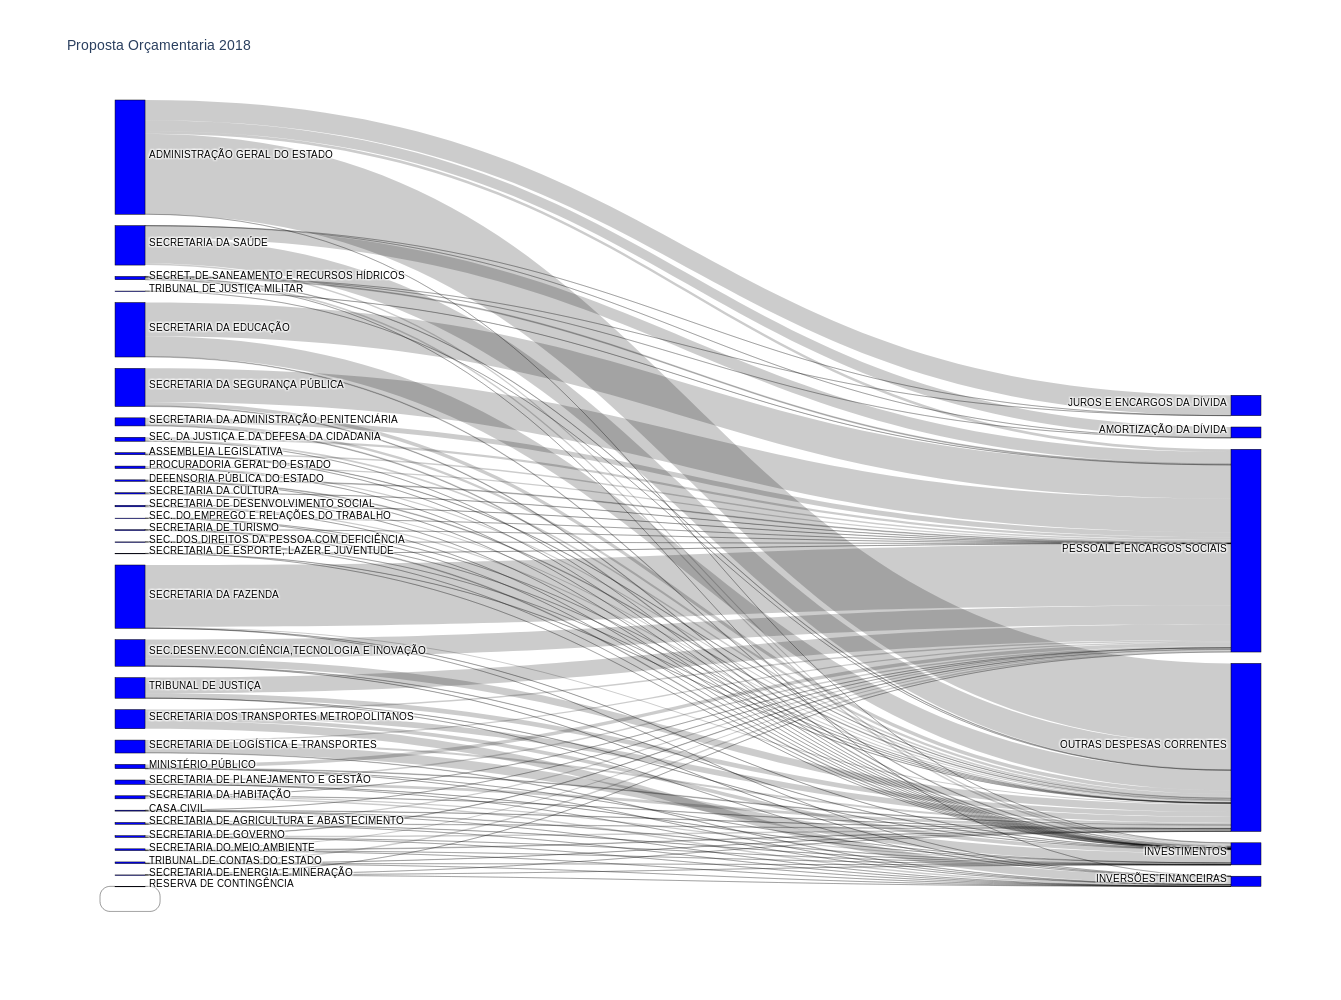

In [9]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 30,
      line = dict(color = "black", width = 0.5),
      label = df['label'],
      color = "blue"
    ),
    link = dict(
      source = df_sankey['num_org'], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = df_sankey['num_grupo'],
      value = df_sankey['valor']
  ))])

layout =  dict(
    title = "Proposta Orçamentaria 2018",
    height = 1000,
#     width = 1400,
    font = dict(
      size = 10
    ),    
)


fig.update_layout(layout)
fig.show()